In [38]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

import pydotplus
from sklearn import tree
from IPython.display import Image
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report, precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc, roc_auc_score

from sklearn import decomposition
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score

from collections import defaultdict
from scipy.stats.stats import pearsonr

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

In [6]:
df = pd.read_csv('datatraining.txt')

In [8]:
df.drop(['date'], axis = 1, inplace = True)

In [9]:
test = pd.read_csv('datatest.txt')

In [11]:
test.drop(['date'], axis = 1, inplace = True)

In [12]:
smt = SMOTE()
X_train, y_train = smt.fit_sample(df.drop(['Occupancy'], axis=1),df.Occupancy)

In [15]:
pca = decomposition.PCA()
decisiontree = DecisionTreeClassifier()

In [25]:
sc = StandardScaler()
pipe = Pipeline(steps=[('sc', sc), ('decisiontree', decisiontree)])
n_components = list(range(1,X_train.shape[1]+1,1))
criterion = ['gini', 'entropy']
max_depth = [4,6,8,10]

In [26]:
parameters = dict(decisiontree__criterion=criterion,
                      decisiontree__max_depth=max_depth)

In [27]:
clf = GridSearchCV(pipe, parameters)

In [28]:
clf.fit(X_train, y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('sc',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('decisiontree',
                                        DecisionTreeClassifier(ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features=None,
                                                               max_leaf_nodes=None,
                                                               min_impurity_decrease=0.0,
                             

In [29]:
print('Best Criterion:', clf.best_estimator_.get_params()['decisiontree__criterion'])
print('Best max_depth:', clf.best_estimator_.get_params()['decisiontree__max_depth'])
# print('Best Number Of Components:', clf.best_estimator_.get_params()['pca__n_components'])
print(); print(clf.best_estimator_.get_params()['decisiontree'])

# Use Cross Validation To Evaluate Model
CV_Result = cross_val_score(clf, X_train, y_train, cv=4, n_jobs=-1)
print(); print(CV_Result)
print(); print(CV_Result.mean())
print(); print(CV_Result.std())

Best Criterion: entropy
Best max_depth: 6

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=6, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

[0.97786093 0.94200187 0.97754911 0.95260368]

0.9625038977237294

0.015656821946393475


In [30]:
clf = DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')
clf = clf.fit(X_train, y_train)

In [31]:
X_test = test.drop(['Occupancy'], axis=1)

In [32]:
y_pred = clf.predict(X_test)
y_pred_tr = clf.predict(X_train)

#### FEATURE IMPORTANCE

In [33]:
for col, imp in zip(X_test.columns, clf.feature_importances_):
    print(col, imp)
    
cols = [(col) for col, imp in zip(X_test.columns, clf.feature_importances_) if imp == 0]
print(cols)

Temperature 0.015945484524738967
Humidity 0.006144341997935841
Light 0.947080702611296
CO2 0.023902669897225042
HumidityRatio 0.006926800968804287
[]


In [34]:
## A QUANTO PARE LA LUCE E' L'UNICO PARAMETRO IMPORTANTE, MAGARI SERVE DEL FEATURE ENGINEERING 

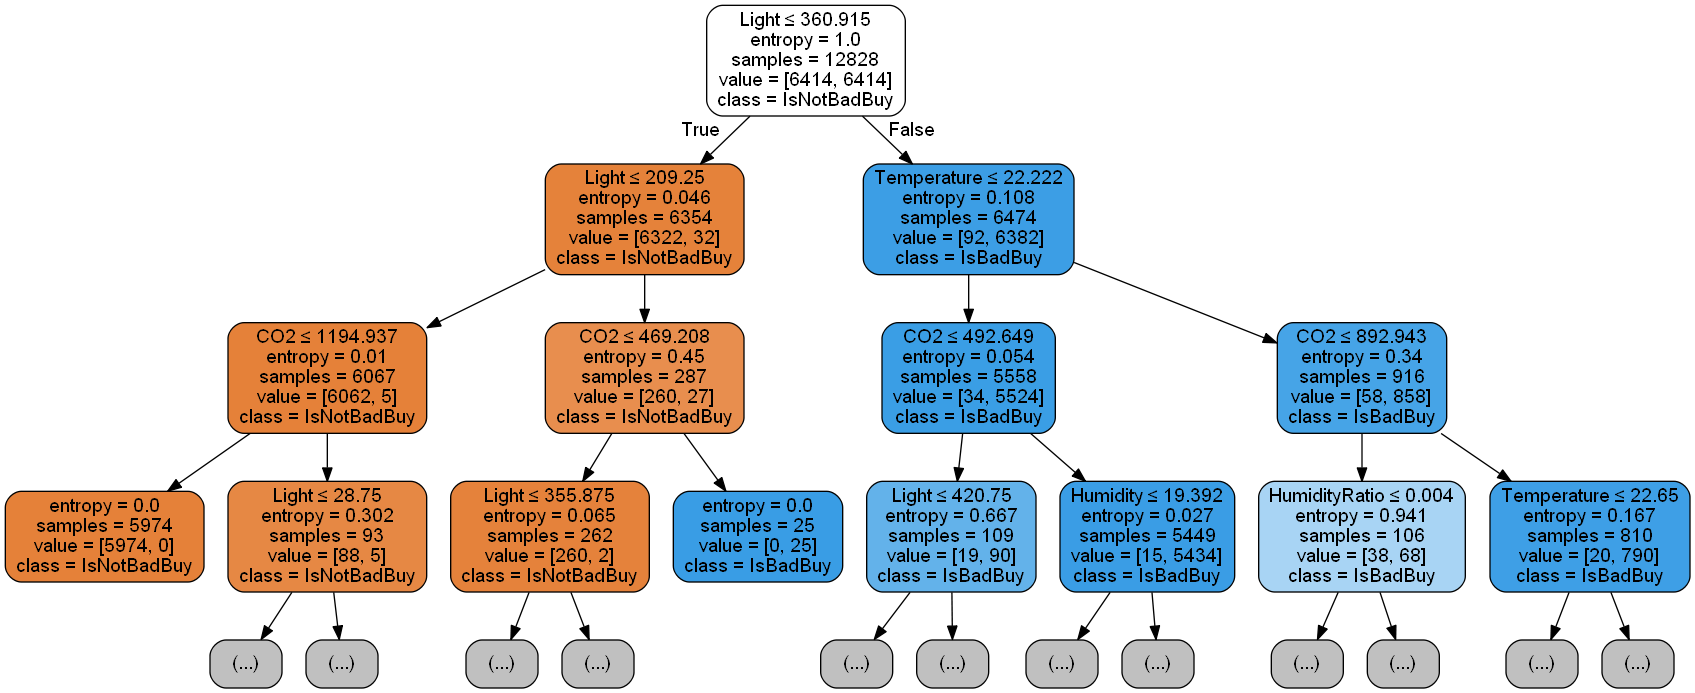

In [35]:
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=X_test.columns,
                                class_names=['IsBadBuy' if x == 1 else 'IsNotBadBuy' for x in clf.classes_],  
                                filled=True, rounded=True,  
                                special_characters=True,
                                max_depth=3)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())

In [39]:
y_test = test.Occupancy

print('Train Accuracy %s' % accuracy_score(y_train, y_pred_tr))
print('Train F1-score %s' % f1_score(y_train, y_pred_tr, average='binary', pos_label=0))
print()

print('Test Accuracy %s' % accuracy_score(y_test, y_pred))
print('Test F1-score %s\n' % f1_score(y_test, y_pred, pos_label=0))

print('Classification report train:')
print(classification_report(y_train, y_pred_tr))

print('Classification report test:')
print(classification_report(y_test, y_pred))

print('precision recall f1 support:')
print(precision_recall_fscore_support(y_test, y_pred, average='binary', pos_label=0))
print()

print('Confusion matrix:')
print(confusion_matrix(y_train, y_pred_tr))

Train Accuracy 0.9976613657623947
Train F1-score 0.9976573481180696

Test Accuracy 0.8682926829268293
Test F1-score 0.9043857259602288

Classification report train:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6414
           1       1.00      1.00      1.00      6414

    accuracy                           1.00     12828
   macro avg       1.00      1.00      1.00     12828
weighted avg       1.00      1.00      1.00     12828

Classification report test:
              precision    recall  f1-score   support

           0       0.84      0.98      0.90      1693
           1       0.95      0.67      0.79       972

    accuracy                           0.87      2665
   macro avg       0.90      0.83      0.85      2665
weighted avg       0.88      0.87      0.86      2665

precision recall f1 support:
(0.839231547017189, 0.980507974010632, 0.9043857259602288, None)

Confusion matrix:
[[6388   26]
 [   4 6410]]


## CROSS VALIDATION

In [42]:
from sklearn.model_selection import cross_val_score

In [43]:
scores = cross_val_score(clf, X_train, y_train, cv=100)
scores

array([0.99224806, 1.        , 1.        , 1.        , 0.96899225,
       1.        , 1.        , 1.        , 0.98449612, 1.        ,
       1.        , 1.        , 0.8372093 , 0.68217054, 0.98449612,
       1.        , 1.        , 0.99224806, 1.        , 1.        ,
       1.        , 0.99224806, 1.        , 1.        , 1.        ,
       0.99224806, 0.93023256, 0.95348837, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       0.9921875 , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.96875   , 1.        , 0.796875  , 1.        ,
       1.        , 0.9921875 , 1.        , 0.9921875 , 1.        ,
       1.        , 1.        , 1.        , 1.        , 0.9921875 ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.9921875 , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

In [44]:
scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='f1_macro')
scores

array([0.97348511, 0.99103657, 0.98440847, 0.98596336, 0.95116718])

In [45]:
scores = cross_val_score(clf, X_train, y_train, cv=10, scoring = 'f1_macro')
scores

array([0.99454392, 0.94765641, 0.98441039, 0.99688229, 0.93505537,
       0.99922057, 0.97504571, 1.        , 0.85689728, 0.99843993])

## TUNING DEI PARAMETRI

#### profondità con f1 score e AUC

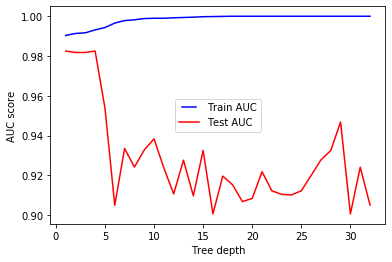

In [46]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
for max_depth in max_depths:
   dt = DecisionTreeClassifier(max_depth=max_depth)
   dt.fit(X_train, y_train)
   train_pred = dt.predict(X_train)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous train results
   train_results.append(roc_auc)
   y_pred = dt.predict(X_test)
   false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
   roc_auc = auc(false_positive_rate, true_positive_rate)
   # Add auc score to previous test results
   test_results.append(roc_auc)
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, 'b', label="Train AUC")
line2, = plt.plot(max_depths, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('Tree depth')
plt.show()